<h1>0. Packages</h1>

In [2]:
from importlib import reload
import numpy as np
import re
import skyfield.sgp4lib as spg4
from   skyfield.api import wgs84
import matplotlib 
import PyQt5

# User defined lib.
import generate_debris as gd
import CoordTransforms as ct
import visualize_deb as vis
import planetary_data

reload(gd)
reload(ct)

matplotlib.use('Agg')
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.stats import norm
import scipy.stats as stats
from enum import IntEnum    
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
from matplotlib import cm
from scipy import integrate
import pandas as pd
from numba import njit, prange


%matplotlib qt5

debris_category = IntEnum('Category', 'rb sc soc')

<h1>1. Data Structure</h1>

<h3>1.1 Satellite Structure</h3>

Creating an object to represent satellite from 3le.txt <br>
May end up using implementation from another package

<b>Data sources:<b><br>
https://www.space-track.org    
https://www.celestrak.com/NORAD/documentation/spacetrk.pdf

<b>Information about 3le/2le:</b><br>
https://en.wikipedia.org/wiki/Two-line_element_set#cite_note-nasahelp-12
https://spaceflight.nasa.gov/realdata/sightings/SSapplications/Post/JavaSSOP/SSOP_Help/tle_def.html

In [3]:
class two_line_element:
    
    def __init__(self, data):
        self.parse_data(data)
        
    def parse_data(self, satelite_data):
        self.title = satelite_data[0]
        line_one = satelite_data[1].split()
        line_two = satelite_data[2].split()

        self.catalog_number = re.search('[0-9]{1,5}', line_one[0]).group()
        self.classification = re.search('[UCS]', line_one[0]).group()

        international_designator = re.search('([0-9]{2})([0-9]{3})(\w{1,3})', line_one[1])
        self.launch_year = international_designator.group(1)
        self.launch_number = international_designator.group(2)
        self.launch_piece =  international_designator.group(3)

        epoch = re.search('([0-9]{2})(\d+\.\d+)', line_one[2])
        self.epoch_year = epoch.group(1)
        self.epoch_day = epoch.group(2)

        self.ballistic_coefficient = float(line_one[3])
        self.mean_motion_double_prime = line_one[4]
        self.BSTAR = line_one[5]

        self.inclination = line_two[1]
        self.right_ascension_of_ascending_node = line_two[2]
        self.eccentricity = line_two[3]
        self.argument_of_perigee = line_two[4]

        mean_anomaly = line_two[5]

<h3>Data structure implementation using spg4 from skyfield library<h3>

In [4]:
# Opening the .txt file
with open("3le.txt") as f:
    txt = f.read()
    
sat_lines = re.findall('(.*?)\n(.*?)\n(.*?)\n', txt)

# Preview of `sat_lines`, each element should be the three lines representing a satellite
print(sat_lines[0])

# Convert each group of 3 lines into a satelite object
def line_element_to_satellite(lines):
    title = lines[0]
    line1 = lines[1]
    line2 = lines[2]
    return spg4.EarthSatellite(line1, line2, name=title)

satellites = [line_element_to_satellite(lines) for lines in sat_lines]

# Verify data structure by finding element representing the ISS
starlink_index = [sat.name for sat in satellites].index("0 STARLINK-31")
starlink = satellites[starlink_index]
print("STARLINK-1026 TLE:")
print(starlink)

('0 VANGUARD 1', '1     5U 58002B   19352.86539842  .00000184  00000-0  20948-3 0  9994', '2     5  34.2610  67.7117 1845282 255.2293  83.7559 10.84789954185624')
STARLINK-1026 TLE:
0 STARLINK-31 catalog #44235 epoch 2019-12-19 06:00:01 UTC


In [ ]:
np.rad2deg(starlink.model.inclo)

<h3>1.2 Celestial Bodies</h3>


de421.bsp is a Ephemerides provided by JPL Horizon which has the calculated positions of celestial bodies within a certain time interval. de421 is commonly used due to its small size and its relativley up to date information

In [5]:
from skyfield.api import load, EarthSatellite
ts = load.timescale(builtin=True)

# Loading the data from de421.bsp using skyfield 
planets = load('de421.bsp')

# Finding the data about Earth
earth = planets["Earth"]

<h3>1.3 Celestial Bodies</h3>

Plotting the satellite data in a 3D view.<br>
Accidently broke my implementation so need to start with the below base and get it to plot the ISS again.

<b>Source:</b> https://space.stackexchange.com/questions/25958/how-can-i-plot-a-satellites-orbit-in-3d-from-a-tle-using-python-and-skyfield

<h1>2. Breakup Models</h1>

<h3>2.1 NASA breakup model</h3>

<b>Implementation:</b> (Found on page 207)<br>
https://www.researchgate.net/publication/295490674_Space_debris_cloud_evolution_in_Low_Earth_Orbit

<b>Alternate implementation:</b><br>
https://gitlab.obspm.fr/apetit/nasa-breakup-model/tree/master

<b>Information:</b><br>
https://digitalcommons.calpoly.edu/cgi/viewcontent.cgi?referer=https://en.wikipedia.org/&httpsredir=1&article=1094&context=theses


<b>Now implemented in file generate_debris.py</b><br>

<h3>2.2 NASA breakup model validation</h3>

In [6]:
# Explosion Case

reload(gd)

m_target = 1000 # [kg]

# Do not need to specify projectile mass, and collision velocity for an explosion
L_c, areas, masses, AM = gd.fragmentation(m_target, 0, 0, False, debris_category.rb, True)

bins = [1e-3, 1e-2, 1e-1, 1, np.inf] # L_c bins in meters
h,b = np.histogram(L_c, bins=bins)

ch = [ { f'>{bins[i]}m':np.sum(h[i:]) for i in range(len(h))}]

df = pd.DataFrame(ch)
df

,>0.001m,>0.01m,>0.1m,>1m
0,378521,9475,219,2


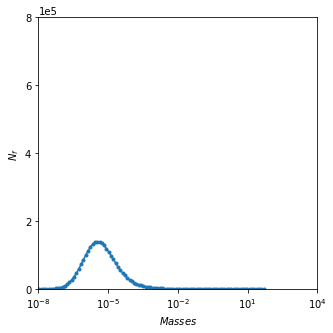

2138855
2015761
1901394
1795260
1698239
1607212
1522893
1443889
1370100
1301188
1237005
1176871
1120492
1067259
1017524
970729
926715
885244
845889
808910
773794
740471
709363
680007
652000
625414
600225
576116
553457
531668
511307
491723
473192
455557
438840
422660
407233
392568
378570
365310
352817
340494
328854
317676
307142
296825
286957
277472
268552
259789
251489
243366
235779
228417
221433
214689
208106
201877
195888
189993
184413
179045
173955
168858
164135
159401
154821
150580
146479
142381
138459
134627
130958
127404
123816
120487
117340
114314
111335
108482
105647
102985
100259
97655
95147
92839
90583
88313
86113
84063
82046
80055
78201
76368
74515
72747
71023
69368
67805
66171
64627
63124
61669
60308
58988
57687
56426
55213
53940
52742
51629
50513
49452
48429
47380
46354
45384
44439
43508
42569
41631
40816
40018
39199
38460
37647
36906
36138
35340
34631
33915
33253
32612
31974
31373
30785
30193
29606
29032
28458
27915
27366
26834
26344
25851
25378
24894
24443
23986
23454
23

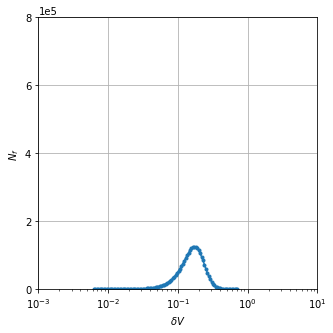

In [22]:
reload(gd)

%matplotlib inline

L_c, areas, masses, AM = gd.fragmentation(1000, 10, 10, True, debris_category.rb, False)
N_fragments_total = L_c.shape[0]
lambda_c = np.log10(L_c)

def create_log_bins(values, nbins=100):
    #return np.geomspace(values.min(), values.max(), nbins)
    bins = np.geomspace(values.min(), values.max(), nbins)
    a = bins[1]/bins[0]
    bins = np.concatenate([[bins[0]/a], bins,[bins[-1]*a]])
    return bins

# # # Validating L_c
# h, b = np.histogram(L_c, bins=create_log_bins(L_c))
# plt.figure(figsize=(5,5))
# plt.xscale('log')
# plt.xlabel(r'$L_{c}$')
# plt.ylabel(r'$N_f$')
# plt.gca().set_xticks([1e-3, 1e-2, 1e-1, 1, 10])
# plt.gca().set_xlim([1e-3,10])
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,5))
# plt.gca().set_yticks([0, 2e5, 4e5, 6e5, 8e5])
# plt.gca().set_ylim([0,8e5])
# plt.plot((b[:-1] + b[1:])/2, h, '.-')
# plt.show()

# # # Validating Areas
# h, b = np.histogram(areas, bins=create_log_bins(areas))
# plt.figure(figsize=(5,5))
# plt.xscale('log')
# plt.xlabel(r'$Areas$')
# plt.ylabel(r'$N_f$')
# plt.gca().set_xticks([1e-8,1e-6, 1e-4, 1e-2, 1, 1e2])
# plt.gca().set_xlim([1e-8,1e2])
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,5))
# plt.gca().set_yticks([0, 2e5, 4e5, 6e5, 8e5])
# plt.gca().set_ylim([0,8e5])
# plt.plot((b[:-1] + b[1:])/2, h, '.-')
# plt.show()

# # Validating Mass & Velocity
h, b = np.histogram(masses, bins=create_log_bins(masses))
plt.figure(figsize=(5,5))
plt.xscale('log')
plt.xlabel(r'$Masses$')
plt.ylabel(r'$N_f$')
plt.gca().set_xticks([1e-8, 1e-5, 1e-2, 10, 1e4])
plt.gca().set_xlim([1e-8,1e4])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,5))
plt.gca().set_yticks([0, 2e5, 4e5, 6e5, 8e5])
plt.gca().set_ylim([0,8e5])
plt.plot((b[:-1] + b[1:])/2, h, '.-')
plt.show()

# # # Validating Velocity
deltaV = np.array(gd.distribution_deltaV(AM, 10, False))
h, b = np.histogram(deltaV, bins=create_log_bins(deltaV))
plt.figure(figsize=(5,5))
plt.xscale('log')
plt.xlabel(r'$\delta V$')
plt.ylabel(r'$N_f$')
plt.gca().set_xticks([1e-3, 1e-2, 1e-1, 1, 10])
plt.gca().set_xlim([1e-3,10])
plt.grid()
plt.plot((b[:-1] + b[1:])/2, h, '.-')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,5))
plt.gca().set_yticks([0, 2e5, 4e5, 6e5, 8e5])
plt.gca().set_ylim([0,8e5])
plt.show()

In [18]:
deltaV 

array(None, dtype=object)

<h3>2.3 and Onward will be alternate breakup models</h3>

<h1>3. Numerical Propagation</h1>

<h3>3.2 Calculating Orbital Debris Properties</h3>

In [ ]:
from skyfield.api import load, EarthSatellite
reload(gd)

ts = load.timescale(builtin=True)

t_fragmentation = ts.now()
geocentric      = starlink.at(t_fragmentation)
init_position   = geocentric.position.m

m_target         = 250   # [kg] (Approx. mass of starlink sat)
m_projectile     = 10    # [kg]
v_impact         = 1     # [km·s^-1] (Measured relative to the target) (Needs to be in km·s^-1)
is_catastrophic  = False
is_explosion     = False

L_c, areas, masses, AM = gd.fragmentation(m_target, m_projectile, v_impact, is_catastrophic, debris_category.soc, is_explosion)
deltaV = np.array(gd.distribution_deltaV(AM, v_impact, False)) # Returns as [km·s^-1]
deltaV = deltaV * 1e3    #[m·s^-1]

<h3>3.3 Converting Cartesian to Keplerian</h3>

In [ ]:
from numpy.linalg import norm
init_position = geocentric.position.m

reload(planetary_data)
reload(ct)

deb_positions       = np.empty((len(AM), 3))
deb_positions[:, :] = init_position[None,:]
deb_velocities      = gd.velocity_vectors(len(AM), geocentric.velocity.m_per_s, deltaV)

keplerian_state     = ct.rv2coe(deb_positions, deb_velocities, planetary_data.earth['mu'])

print(keplerian_state.shape)
# Removing fragments that would renter earth
periapsis           = keplerian_state[0, :] * (1 - keplerian_state[1, :])
I                   = np.argwhere(periapsis > pd.earth['radius'])
keplerian_state     = np.squeeze(keplerian_state[:, I])
areas  = areas[I].flatten()  # When doing the indexing , a 1d dim being added which is unneccesary
masses              = masses[I].flatten() # When doing the indexing , a 1d dim being added which is unneccesary

In [ ]:
rand_index = 1

print("Cartesian")
print("r: ", deb_positions[rand_index, :])
print("v: ", deb_velocities[rand_index, :])
print("m: ", masses[rand_index])
print("m_E: ", planetary_data.earth['mass'])
print("Keplerian")
ks_rand = keplerian_state[:, rand_index]
print("a: ", ks_rand[0]) # a is tyically off in the thousands place
print("e: ", ks_rand[1])
print("i: ", ks_rand[2])
print("Omega: ", ks_rand[3]) 
print("omega: ", ks_rand[4])
print("M: ", ks_rand[5])
print("nu: ", ks_rand[6])
print()

<h3>3.4 Testing coverting back to Cartesian</h3>

In [ ]:
reload(ct)

%matplotlib notebook

indexes = np.random.default_rng().choice(keplerian_state.shape[1], size=1000, replace=False)
ks_sample = keplerian_state[:, indexes]

cartesian_state = np.array(ct.coe2rv_many(k=planetary_data.earth['mu'],
                              p=ks_sample[7, :],
                              ecc=ks_sample[1, :],
                              inc=ks_sample[2, :],
                              raan=ks_sample[3, :],
                              argp=ks_sample[4, :],
                              nu=ks_sample[6, :]))
radius_earth = planetary_data.earth['radius']
r = cartesian_state[0, :, :]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r[:, 0], r[:, 1], r[:, 2])
ax.set_xlim3d([-radius_earth-1000*1e3, radius_earth+1000*1e3])
ax.set_xlabel('X (m)')

ax.set_ylim3d([-radius_earth-1000*1e3, radius_earth+1000*1e3])
ax.set_ylabel('Y (m)')

ax.set_zlim3d([-radius_earth-1000*1e3, radius_earth+1000*1e3])
ax.set_zlabel('Z (m)')

_u, _v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
_x = radius_earth*np.cos(_u)*np.sin(_v)
_y = radius_earth*np.sin(_u)*np.sin(_v)
_z = radius_earth*np.cos(_v)

ax.plot_surface(_x, _y, _z, cmap=cm.coolwarm)
plt.show()

In [ ]:
keplerian_state.shape
masses.shape

<h3>3.4 Debris Cloud formation</h3>

In [ ]:
## Shrink number of debris being used
indexes = np.random.default_rng().choice(keplerian_state.shape[1], size=250, replace=False)

ks = keplerian_state[:, indexes]
masses = masses[indexes]
areas = areas[indexes]
deb_positions = deb_positions[indexes, :]
deb_velocities = deb_velocities[indexes, :]

print(masses.shape)

In [ ]:
np.savez("debris.npz",
         keplerian_states=ks,
         masses=masses,
         areas=areas,
         deb_positions=deb_positions,
         deb_velocities=deb_velocities)

In [ ]:
container = np.load('debris.npz')
ks = container['keplerian_states']
masses = container['masses']
areas = container['areas']
deb_positions = container['deb_positions']
deb_velocities = container['deb_velocities']

<h4>3.4.1 Ellisoid formation</h4>

In [ ]:
import Perturbations as OP
import planetary_data as pd
from Perturbations import null_perts

reload(OP)

# Cleanup states to remove any fragments that would deorbit, given no perturbations
periapsis     = ks[0, :] * (1 - ks[1, :])
I             = np.argwhere(periapsis > pd.earth['radius'])
ks_pruned     = np.squeeze(ks[:, I])
T             = ks_pruned[8, :]
areas_pruned  = areas[I].flatten()  # When doing the indexing , a 1d dim being added which is unneccesary
masses_pruned = masses[I].flatten() # When doing the indexing , a 1d dim being added which is unneccesary

# Propagate orbit for a period of time
perts = null_perts()
perts['aero'] = True
perts['J2']   = True
op = OP.OrbitPropagator(ks_pruned, areas_pruned, masses_pruned, [0, 20*np.ceil(max(T))], 60*5, perts=perts)
op.propagate_orbit()

# Get the cartesian state representation
cartesian_states = op.cartesian_representation()


<h4>3.4.2 Particle Debris flux</h4>

Using a particle flux to determine when the fragments of the debris have finished the formation of the ring. Indicating the end of the first phase of the debris cloud formation. This is accomplished by creating an xz plane and detecting when particles have switched from one side to the other. This approach will cause a peak as fragments pass through that becomes uniform as the debris becomes uniformly spread out.

In [ ]:
import time
import matplotlib.dates as mdates
from dateutil import tz

def fragmentation_flux(X):
    return np.sum((X[:-1, :, 1] < 0) & (X[1:, :, 1] > 0), axis=1)
    
position = cartesian_states[:, 0, :, :]
flux = fragmentation_flux(position)

<h4>3.4.3 Convergence of the flux</h4>

The next step is determining when the fragments have ended the torroid formation phase. This occurs when the fragments are approximately uniformally spread out. We can check to see when the flux meets a convergence criterion to determine when this happens.

In [ ]:
w = 25 # Window of points to look at
tol = 0.5
convergence_ratio = np.array([np.var(flux[i:i+w])/np.mean(flux[i:i+w]) for i in range(len(flux))])
intersection_index = np.argwhere(convergence_ratio <= tol).flatten()[0] # Grabbing the first point that meets the criteria

In [ ]:
import datetime

# datetimes
t_flux = t_fragmentation.utc_datetime() + np.array(range(len(flux))) * datetime.timedelta(minutes = 5)

# Creating Flux v. Time plot

plt.plot(mdates.date2num(t_flux), flux, label='Flux')
plt.axvline(x=t_flux[intersection_index], color='r',ls=':', label='Intersection')
plt.xlim([t_flux[0], t_flux[-1]])
formatter = mdates.DateFormatter('%m/%d %H:%M UTC', tz=tz.UTC)
ax.xaxis.set_major_formatter(formatter)
plt.legend(frameon=False)
plt.xticks(rotation=60)
plt.xlabel("Date-Time")
plt.ylabel("Flux")
plt.tight_layout()
plt.show()

# Creating Convergence Ratio v. Time plot
plt.plot(mdates.date2num(t_flux), convergence_ratio, color='orange', label='Convergence ratio')
plt.axhline(y=tol, color='k', ls=":", label='Threshold')
plt.axvline(x=t_flux[intersection_index], color='r',ls=':', label='Intersection')
formatter = mdates.DateFormatter('%m/%d %H:%M UTC', tz=tz.UTC)
ax.xaxis.set_major_formatter(formatter)
plt.legend(frameon=False)
plt.xticks(rotation=60)
plt.xlim([t_flux[0], t_flux[-1]])
plt.yscale('symlog')
plt.xlabel("Date-Time")
plt.ylabel("Convergence ratio")
plt.tight_layout()
plt.show()

<h4>3.4.4 End of band formation</h4>

Now that the band has formed, we can shift away from propagating the exact position of each fragments and inplace propgate their changes in eccentricity and semi major axis due to drag. To do this first we must get the final states of the debris after the band has formed.

In [ ]:
# Subsetting data such that just covers the formation of the band, i.e has uniformally spread out.
# cs_band = band cartesian state
# ks_band = band keplerian state

reload(vis)

cs_toroid = cartesian_states[:intersection_index, :, :, :]
ks_toroid = op.states[0:intersection_index, :, :]
op.states = ks_toroid

# Creating visual
data = np.swapaxes(cs_toroid,0,1)[0, :, :, :]

vis.generate_visualization(data, "Band_Formation", op.cb)
op.states.shape

<h3> 4.0.0 Implementing Perturbations </h3>

In [ ]:
op.tspan[-1] = 60 * 60 * 24 * 300
op.dt = 60 * 60 * 24
de, da, domega, dOmega = op.propagate_perturbations()

In [ ]:
da_0 = da[:, 0]
I = np.argwhere((da_0 > 6800) & (da_0 < 7000)).flatten()
I = np.random.choice(I, 5)

In [ ]:
plt.close()
times = np.arange(op.tspan[0], op.tspan[-1], op.dt)
for i in I:
    curve = da[i, :]
    trimmed = np.trim_zeros(curve)
    plt.plot(times[:len(trimmed)], trimmed, label='Area: '+'{:0.3e}'.format(areas_pruned[i])+'[m^2]')
plt.legend()
plt.plot()

In [ ]:
print(times / (60 * 60 * 24), ' days')

In [ ]:
op.tspan[0]